In [19]:
#Hàm load model tốt nhất dựa trên tập test của fashion_mnist
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import accuracy_score
def evaluate_model(model, x_test,y_test):
    y_pred=np.argmax(model.predict(x_test), axis=1)
    return accuracy_score(y_test,y_pred)
def evaluate_folder_model(model_dir):
    max_accuracy=0
    max_model_path=''
    fashion_set=fashion_mnist.load_data()
    (x_train, y_train), (x_test, y_test) = fashion_set
    x_test=np.array(x_test,dtype = 'float32')
    x_test=x_test/255.0
    x_test=x_test.reshape(x_test.shape[0], 28, 28, 1)
    x_channel_1=x_test
    x_channel_3=x_test=x_test.repeat(3, axis=-1)
    for file in os.listdir(model_dir):
        if '.'in file:
            print(f'Found file: {file}')
            if 'transfer' in file:
                x_test=x_channel_3
            else:
                x_test=x_channel_1
            model_path=os.path.join(model_dir,file)
            model=keras.models.load_model(model_path)
            accuracy=evaluate_model(model,x_test,y_test)
            print('accuracy: ',end='')
            print(accuracy)
            if accuracy>max_accuracy:
                max_accuracy=accuracy
                max_model_path=model_path
        else:
            print(f'Found folder (not load): {file}')
    return max_model_path,max_accuracy
model_dir=r'D:\PythonWorkspace\PythonMain\MNIST_DOSOMETHING\FashionMNIST\model_training'
print(evaluate_folder_model(model_dir))


Found file: model_before_tuning.h5
313/313 [==============================] - 3s 10ms/step
accuracy: 0.9052
Found folder (not load): model_random_stored
Found file: model_transfer_CNN_epoch_01_val_acc_0.79 (1).h5
313/313 [==============================] - 40s 124ms/step
accuracy: 0.7798
Found file: model_transfer_CNN_epoch_01_val_acc_0.79 (2).h5
313/313 [==============================] - 46s 143ms/step
accuracy: 0.806
Found file: model_using_random_search.h5
313/313 [==============================] - 3s 11ms/step
accuracy: 0.9008
Found folder (not load): transfer_model
Found file: transfer_model.h5
313/313 [==============================] - 42s 129ms/step
accuracy: 0.8034
Found file: transfer_model_CNN_epoch_01_val_acc_0.79 (3).h5
313/313 [==============================] - 43s 132ms/step
accuracy: 0.8417
('D:\\PythonWorkspace\\PythonMain\\MNIST_DOSOMETHING\\FashionMNIST\\model_training\\model_before_tuning.h5', 0.9052)


In [2]:
#Create data before training
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import savefig
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Conv1D, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import pandas as pd
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import MaxPooling2D, AveragePooling2D
from sklearn.metrics import accuracy_score
fashion_set = fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_set
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_process = X/255
        return X_process.reshape(X.shape[0], 28, 28, 1)
processor = Pipeline([
    ('Process', Preprocessor())
])
#Split Data from train set to train and cross set
from sklearn.model_selection import train_test_split
X_train_, X_cross_, y_train_,  y_cross = train_test_split(X_train, y_train, random_state=42, train_size=0.8, stratify=y_train)
X_train_process = processor.fit_transform(X_train_)
X_cross_process = processor.transform(X_cross_)



from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.1,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode='nearest', cval=0)
data_generator.fit(X_train_process)
batch = data_generator.flow(X_train_process, y_train_, seed=42, batch_size=128)
batch.image_data_generator
X_batch, y_batch = data_generator.flow(X_train_process, y_train_, batch_size=10, shuffle=False).next()
X_augment, y_augment = data_generator.flow(X_train_process, y_train_, batch_size=X_train_process.size).next()
X_augment_train = np.concatenate((X_augment, X_train_process), axis=0)
y_augment_train = np.concatenate((y_augment, y_train_), axis=0)
print(y_augment_train.shape)
shuffle_indices = np.random.permutation(X_augment_train.shape[0])
X_augment_train = X_augment_train[shuffle_indices]
y_augment_train = y_augment_train[shuffle_indices]
def expand_gray_scale(X):
    X_3_channel = X.repeat(3, axis=-1) #expand to 3 dimension
    return X_3_channel
X_augment_train_3 = expand_gray_scale(X_augment_train)
X_cross_3 = expand_gray_scale(X_cross_process)
X_test_process = processor.transform(X_test)
X_test_3 = expand_gray_scale(X_test_process)

4422102/4422102 [==============================] - 0s 0us/step
(96000,)


In [ ]:
transfer_model = Sequential()
transfer_model.add(ResNet50(include_top=False,pooling='avg', weights='imagenet'))

transfer_model.add(Dense(512,activation='relu'))
transfer_model.add(Dense(10, activation='linear'))

transfer_model.layers[0].trainable=True #Huấn luyện từ lớp 150 trở đi của resnet50
for layer in transfer_model.layers[0].layers[:150]:
    layer.trainable=False
transfer_model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24641930 (94.00 MB)
Trainable params: 11044362 (42.13 MB)
Non-trainable params: 13597568 (51.87 MB)
_________________________________________________________________


In [ ]:
folder=r'/model_training/transfer_model/'
checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath=folder+'transfer_model_CNN_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
print(X_augment_train_3.shape)
transfer_model.fit(X_augment_train_3, y_augment_train,epochs=50,verbose=1, batch_size=32,validation_data=(X_cross_3, y_cross), callbacks=[checkpoint])

(96000, 28, 28, 3)
Epoch 1/50
2998/3000 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.7484

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3000/3000 [==============================] - 61s 20ms/step - loss: 0.6857 - accuracy: 0.7484 - val_loss: 0.5522 - val_accuracy: 0.7927
Epoch 2/50
3000/3000 [==============================] - 55s 18ms/step - loss: 0.5454 - accuracy: 0.7925 - val_loss: 0.5894 - val_accuracy: 0.7811
Epoch 3/50
3000/3000 [==============================] - 61s 20ms/step - loss: 0.4987 - accuracy: 0.8084 - val_loss: 0.5156 - val_accuracy: 0.8154
Epoch 4/50
3000/3000 [==============================] - 57s 19ms/step - loss: 0.4625 - accuracy: 0.8227 - val_loss: 0.5223 - val_accuracy: 0.8098
Epoch 5/50
3000/3000 [==============================] - 57s 19ms/step - loss: 0.4349 - accuracy: 0.8330 - val_loss: 0.4331 - val_accuracy: 0.8430
Epoch 6/50
3000/3000 [==============================] - 55s 18ms/step - loss: 0.4144 - accuracy: 0.8394 - val_loss: 0.4346 - val_accuracy: 0.8394
Epoch 7/50
3000/3000 [==============================] - 55s 18ms/step - loss: 0.3978 - accuracy: 0.8462 - val_loss: 0.4954 - val_accura

In [ ]:
model_history = pd.DataFrame(transfer_model.history.history)
model_history

,loss,accuracy,val_loss,val_accuracy
0,0.685692,0.748417,0.552223,0.792667
1,0.545434,0.792479,0.589386,0.781083
2,0.498714,0.808375,0.515615,0.815417
3,0.462538,0.822719,0.522330,0.809750
4,0.434887,0.833042,0.433128,0.843000
5,0.414370,0.839365,0.434613,0.839417
6,0.397841,0.846229,0.495386,0.827417
7,0.378660,0.854479,0.430340,0.848750
8,0.362574,0.859250,0.409251,0.860167
9,0.351111,0.864177,0.452892,0.849083


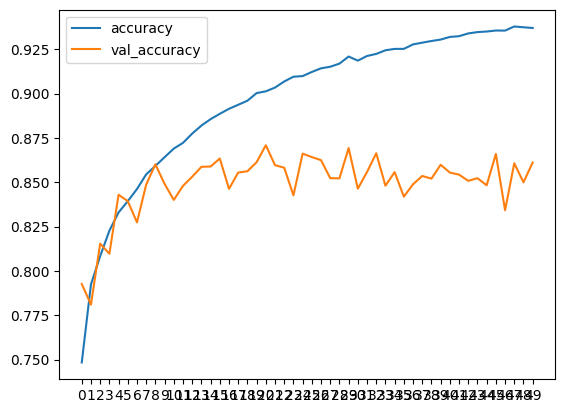

In [ ]:
model_history.loc[:,['accuracy','val_accuracy']].plot()
k=plt.xticks(model_history.index)
savefig('acc_vs_val_acc_before_tuning_transfer_model.png')